# Simple linear regression

Let's return to the infant mortality dataset that we used in the previous section. We again load the dataset using `pandas`:

In [1]:
import pandas as pd

mortality_data = pd.read_csv('datasets/infant_mortality.csv')
mortality_data = mortality_data.dropna()
mortality_data.head()

,country,income,infant_mortality,region,oil
0,Australia,3426,26.7,Asia,no
1,Austria,3350,23.7,Europe,no
2,Belgium,3346,17.0,Europe,no
3,Canada,4751,16.8,Americas,no
4,Denmark,5029,13.5,Europe,no


Now we can transform the features `income` and `infant_mortality` to the log scale, and plot a joint scatter plot of them.

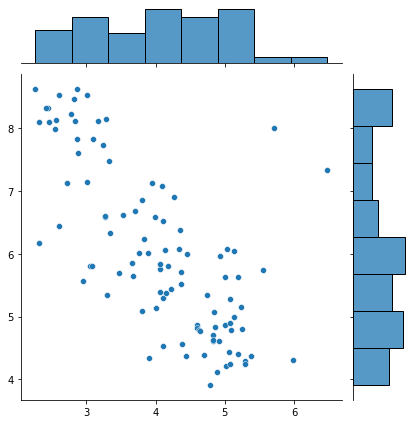

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# calling .to_numpy() on a column of a DataFrame gives you a numpy array back
log_income = np.log(mortality_data["income"].to_numpy())
log_infant_mortality = np.log(mortality_data["infant_mortality"].to_numpy())

sns.jointplot(x=log_infant_mortality, y=log_income)
plt.xlabel("log(Infant mortality rate)", fontsize=12)
plt.ylabel("log(Per-capita income)", fontsize=12)
plt.show()

## Computing correlation
Suppose we wanted to quantify the negative relationship between log-mortality and log-income. A simple way to do this would be with the Pearson correlation. For two vectors of observations $(x_1,\dots, x_n)$ and $(y_1,\dots,y_n)$, their Pearson correlation is computed as

$$
r = \frac{\text{Cov}(X, Y)}{\sqrt{\text{Var}(X)\text{Var}(Y)}} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^n (x_i-\bar{x})^2 \sum_{i=1}^n (y_i - \bar{y})^2}}.
$$

Let's write a simple python function that computes the pearson correlation.

In [3]:
def pearson_corr(x,y):
    # first compute the means of the two vectors
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    # compute numerator (1/n)*\sum_i (x_i - x_bar)*(y_i - y_bar)
    cov_xy = np.sum((x-x_bar)*(y-y_bar))/len(x)

    # compute the variance of x and y
    var_x = np.sum((x-x_bar)**2)/len(x)
    var_y = np.sum((y-y_bar)**2)/len(y)

    # compute the correlation
    r = cov_xy/np.sqrt(var_x*var_y)

    return r

Now we can use this function to compute the correlation between log-income and log-mortality:

In [4]:
r = pearson_corr(log_income, log_infant_mortality)
r

-0.7086068160294183

Note that the Pearson correlation is bound between -1 and 1, with -1 indicating a perfect negative relationship between the features, and +1 indicating a perfect positive relationship between the features. Thus the observed value of $\approx -.71$ suggesting, as we can see visually, a strong negative relationship between log-infant mortality and log-per-capita income.

Of course, we don't really need to implement our own python function every time we want to compute the Pearson correlation. It's conveniently implemented in the `scipy.stats` library in python (which also includes a number of other methods that will be useful for statistics).

In [5]:
from scipy.stats import pearsonr

r_2, _ = pearsonr(log_income, log_infant_mortality)
r_2

-0.7086068160294183

Indeed, this method gives us the same result as we got with our own function.

## Finding the line of best fit by minimizing the sum of squares
Instead of just computing the correlation between the two features, we could also try to model the relationship by fitting a line to data. In particular, we want to find numbers $\alpha$ and $\beta$ such that

$$
\log(\text{per-capita income}) \approx \alpha + \beta \cdot \log(\text{infant mortality})
$$

To do this, we just need to find the values of $\alpha$ and $\beta$. Let's denote our obsevations of log-per-capita income by $(x_1,\dots,x_n)$ and those of log-infant mortality as $(y_1,\dots,y_n)$. Then one way to quantiatively choose $\alpha,\beta$ is by minimizing the sum of squared errors:

$$
\text{SSE}(\alpha, \beta) = \frac{1}{n}\sum_{i=1}^n (y_i - (\alpha +\beta x_i))^2
$$

With a little bit of calculus, we can check that

$$
\begin{align*}
\frac{\partial}{\partial \alpha}\text{SSE} &= -2\sum_{i=1}^n (y_i - \alpha - \beta x_i) && \text{and}\\
\frac{\partial}{\partial \beta}\text{SSE} &= -2\sum_{i=1}^n x_i(y_i - \alpha - \beta x_i)
\end{align*}
$$

If we set these two derivatives equal to zero (to find the minimizers), we obtain the estimates $\hat{\alpha}$ and $\hat{\beta}$:

$$
\begin{align*}
\hat{\alpha} &= \bar{y} - \beta \bar{x}\\
\hat{\beta} &= \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i-\bar{x})^2}
\end{align*}
$$

Note that the expression for $\hat{\beta}$ looks very reminiscent of our equation for the Pearson correlation. Let's write a python function that takes in two arrays $(x_1,\dots,x_n)$ and $(y_1,\dots,y_n)$ computes the estimates $\hat{\alpha}$ and $\hat{\beta}$.

In [6]:
def fit_line(x, y):
    # first compute the means of the two vectors
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    # compute numerator (1/n)*\sum_i (x_i - x_bar)*(y_i - y_bar)
    cov_xy = np.sum((x-x_bar)*(y-y_bar))/len(x)

    # compute the variance of x and y
    var_x = np.sum((x-x_bar)**2)/len(x)

    # compute beta_hat
    beta_hat = cov_xy/var_x

    # compute alpha_hat
    alpha_hat = y_bar - beta_hat*x_bar

    return alpha_hat, beta_hat

Now let's use this to compute the coefficients for the line best fititng our data.

In [7]:
alpha_hat, beta_hat = fit_line(log_infant_mortality, log_income)
alpha_hat, beta_hat

(10.015182459015683, -0.9811044324011452)

The intercept term $\hat{\alpha} \approx 10.02$ indicates that the best fit line crosses the y-axis at $y\approx 10.02$. The coefficient for the slope $\hat{\beta} \approx -0.98$ again indicates the negative relationship between log-income and log-infant mortality. Let's overlay this line on top of our joint scatterplot.

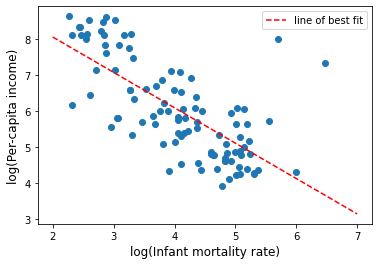

In [8]:
xx = np.linspace(2,7,5)
yy = alpha_hat + beta_hat*xx
plt.scatter(log_infant_mortality, log_income)
plt.plot(xx, yy, color='red', linestyle='--', label='line of best fit')
plt.xlabel("log(Infant mortality rate)", fontsize=12)
plt.ylabel("log(Per-capita income)", fontsize=12)
plt.legend()
plt.show()

## Interpreting the coefficients of a line of best fit

**todo**